In [47]:
# ALWAYS RUN THIS CELL
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))
display(HTML("<style>.container {width:100% !important; }</style>"))

In [39]:
from pathlib import Path

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import numpy as np

import tensorly as tl

In [40]:
%load_ext autoreload
%autoreload 2
import bnpm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import data

In [13]:
directory_data_tca = r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/'

In [16]:
paths_data_tca = bnpm.path_helpers.find_paths(
    dir_outer=directory_data_tca,
    reMatch='VQT_Analyzer.h5',
    depth=4,
    natsorted=True,
)
dates_data_tca = [Path(p).parts[-4] for p in paths_data_tca]

dates_data_tca

['20230430',
 '20230501',
 '20230502',
 '20230503',
 '20230504',
 '20230505',
 '20230506',
 '20230507',
 '20230508',
 '20230509',
 '20230510',
 '20230511',
 '20230512',
 '20230514',
 '20230515',
 '20230516',
 '20230517',
 '20230518',
 '20230519',
 '20230520',
 '20230521',
 '20230522',
 '20230523',
 '20230524',
 '20230525',
 '20230526',
 '20230527',
 '20230528',
 '20230529',
 '20230530',
 '20230531',
 '20230601']

In [17]:
data_tca = {d: bnpm.h5_handling.simple_load(p, return_dict=False,) for d,p in tqdm(zip(dates_data_tca, paths_data_tca))}

0it [00:00, ?it/s]

make a subsampled and concatenated version

In [13]:
n_samples_per_session = 2000

spectrograms_subsampled = {}

for date, data in tqdm(data_tca.items()):
    idx = np.sort(np.random.choice(np.arange(data['spectrograms']['0'].shape[-1]), size=min(n_samples_per_session, data['spectrograms']['0'].shape[-1]), replace=False))

    spectrograms_subsampled[date] = data['spectrograms']['0'][..., idx]

  0%|          | 0/32 [00:00<?, ?it/s]

In [37]:
DEVICE_bigTCA = bnpm.torch_helpers.set_device(use_GPU=False)

device: 'cpu'


In [18]:
spectrograms_cat = np.concatenate(list(spectrograms_subsampled.values()), axis=-1)

In [19]:
spectrograms_cat = spectrograms_cat.transpose(-1, 2, 0, 1)
spectrograms_cat = spectrograms_cat.reshape(spectrograms_cat.shape[0], spectrograms_cat.shape[1], -1)
spectrograms_cat = torch.as_tensor(spectrograms_cat, dtype=torch.float32, device=DEVICE_bigTCA)

In [29]:
# np.save('/media/rich/bigSSD/downloads_tmp/spec_cat.npy', spectrograms_cat.numpy())

In [30]:
# spectrograms_cat = np.load('/media/rich/bigSSD/downloads_tmp/spec_cat.npy')

In [20]:
bnpm.misc.estimate_array_size(spectrograms_cat)

17.252352

In [21]:
bnpm.torch_helpers.clear_cuda_cache()

In [23]:
tl.set_backend('pytorch')

In [24]:
model = tl.decomposition.CP_NN_HALS(
    rank=10,
    n_iter_max=100,
    init='random',
    svd='truncated_svd',
    tol=1e-07,
    sparsity_coefficients=None,
    fixed_modes=None,
    nn_modes='all',
    exact=False,
    verbose=True,
#     normalize_factors=False,
#     cvg_criterion='abs_rec_error',
#     random_state=None,
)

In [25]:
model.fit(spectrograms_cat)

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/roicat/lib/python3.11/site-packages/tensorly/backend/pytorch_backend.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(


reconstruction error=0.32663604617118835
iteration 1, reconstruction error: 0.5896908640861511, decrease = -0.26305481791496277
iteration 2, reconstruction error: 0.6161264181137085, decrease = -0.026435554027557373
iteration 3, reconstruction error: 0.6261373162269592, decrease = -0.010010898113250732
iteration 4, reconstruction error: 0.6309921741485596, decrease = -0.004854857921600342
iteration 5, reconstruction error: 0.6339074969291687, decrease = -0.002915322780609131
iteration 6, reconstruction error: 0.6359459757804871, decrease = -0.0020384788513183594
iteration 7, reconstruction error: 0.6377460360527039, decrease = -0.0018000602722167969
iteration 8, reconstruction error: 0.6394460201263428, decrease = -0.001699984073638916
iteration 9, reconstruction error: 0.6408548355102539, decrease = -0.0014088153839111328
iteration 10, reconstruction error: 0.6418330669403076, decrease = -0.000978231430053711
iteration 11, reconstruction error: 0.6424534320831299, decrease = -0.000620

Rank-10 Non-Negative CP decomposition.

In [26]:
factors = model.decomposition_.factors

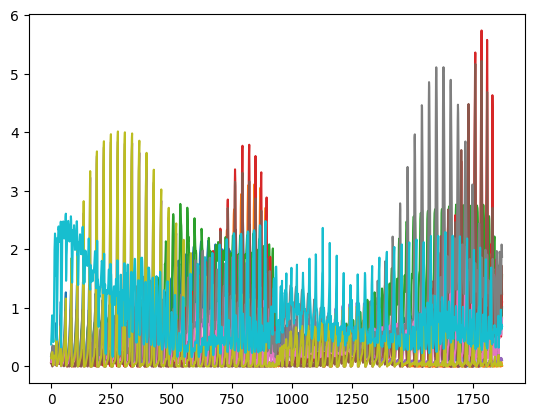

In [27]:
plt.figure()
plt.plot(factors[2].cpu())

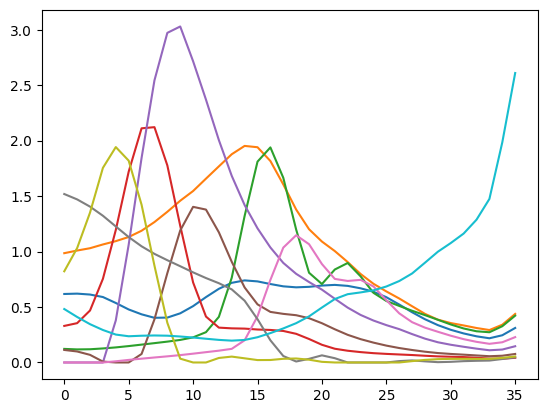

In [28]:
plt.figure()
plt.plot(factors[1].cpu())

rearrange factors

In [35]:
factors_named = {
    'time': factors[0],
    'frequency': factors[1],
    '(points (xy))': factors[2],
}

Save factors

In [36]:
bnpm.h5_handling.simple_save(
    dict_to_save=factors_named,
    path=r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/run_20230701/bigTCA.h5',
)

refit temporal factor for each day

In [40]:
DEVICE_smallTCA = bnpm.torch_helpers.set_device(use_GPU=True)

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)


In [75]:
init_bt = tl.cp_tensor.CPTensor((None, [torch.as_tensor(t, dtype=torch.float32, device='cpu') for t in factors[:]]))

In [74]:
import copy

In [86]:
bnpm.torch_helpers.clear_cuda_cache()

In [113]:
factors_refit = {}
for date, data in tqdm(data_tca.items()):
    data_rs = torch.as_tensor(data['spectrograms']['0'][:], dtype=torch.float32, device='cpu')
    
    data_rs = data_rs.permute(-1, 2, 0, 1)
    data_rs = data_rs.reshape(data_rs.shape[0], data_rs.shape[1], -1).permute(1,2,0)
    data_rs = data_rs.to(DEVICE_smallTCA)
    
    init_bt_i = copy.deepcopy(init_bt).factors
    init_bt_i[0] = init_bt_i[0][torch.randint(low=0, high=init_bt_i[0].shape[0], size=(data_rs.shape[2],)), :]
    init_bt_i = [torch.as_tensor(t, dtype=torch.float32, device=DEVICE_smallTCA) for t in init_bt_i]
    init_bt_i = [init_bt_i[ii] for ii in [1,2,0]]

    model = tl.decomposition.CP_NN_HALS(
        rank=10,
        n_iter_max=100,
#         init='random',
        init=tl.cp_tensor.CPTensor((None, init_bt_i)),
        svd='truncated_svd',
        tol=1e-07,
        sparsity_coefficients=None,
        fixed_modes=[0,1],
        nn_modes='all',
        exact=False,
        verbose=True,
    #     normalize_factors=False,
    #     cvg_criterion='abs_rec_error',
    #     random_state=None,
    )
    
    model.fit(tensor=data_rs)
    
    factors_refit[date] = copy.deepcopy(model.decomposition_.factors)
    
    del data_rs
    bnpm.torch_helpers.clear_cuda_cache()

  0%|          | 0/32 [00:00<?, ?it/s]

reconstruction error=0.43965479731559753
iteration 1, reconstruction error: 0.43965479731559753, decrease = 0.0
PARAFAC converged after 1 iterations
reconstruction error=0.4513958692550659
iteration 1, reconstruction error: 0.451396107673645, decrease = -2.384185791015625e-07
iteration 2, reconstruction error: 0.4513958692550659, decrease = 2.384185791015625e-07
iteration 3, reconstruction error: 0.451396107673645, decrease = -2.384185791015625e-07
iteration 4, reconstruction error: 0.4513958692550659, decrease = 2.384185791015625e-07
iteration 5, reconstruction error: 0.451396107673645, decrease = -2.384185791015625e-07
iteration 6, reconstruction error: 0.451396107673645, decrease = 0.0
PARAFAC converged after 6 iterations
reconstruction error=0.4457342326641083
iteration 1, reconstruction error: 0.4457339346408844, decrease = 2.980232238769531e-07
iteration 2, reconstruction error: 0.4457339346408844, decrease = 0.0
PARAFAC converged after 2 iterations
reconstruction error=0.4586659

In [ ]:
dict_keys(['(xy points)', 'frequency', 'time'])

In [133]:
factors_refit_named = {date: {
    '(xy points)': f[1].cpu().numpy(),
    'frequency': f[0].cpu().numpy(),
    'time': f[2].cpu().numpy(),
} for date, f in factors_refit.items()}

In [135]:
factors_refit_separated = {date: {'factors_rearranged': {'0': f}} for date, f in factors_refit_named.items()}

In [127]:
bnpm.h5_handling.simple_save(
    dict_to_save=factors_refit_named,
    path=r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/run_20230701/factors_refit_bigTCA.h5',
    write_mode='w'
)

In [138]:
[bnpm.h5_handling.simple_save(
    dict_to_save=f,
    path=f'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/run_20230701/factors_refit/{date}/TCA.h5',
    write_mode='w',
) for date, f in factors_refit_separated.items()]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

visualize

In [27]:
%load_ext autoreload
%autoreload 2
import face_rhythm as fr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
directory_data_vqt = r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/'

paths_data_vqt = bnpm.path_helpers.find_paths(
    dir_outer=directory_data_vqt,
    reMatch='VQT_Analyzer.h5',
    depth=4,
    natsorted=True,
)
dates_data_vqt = [Path(p).parts[-4] for p in paths_data_vqt]

dates_data_vqt

['20230430',
 '20230501',
 '20230502',
 '20230503',
 '20230504',
 '20230505',
 '20230506',
 '20230507',
 '20230508',
 '20230509',
 '20230510',
 '20230511',
 '20230512',
 '20230514',
 '20230515',
 '20230516',
 '20230517',
 '20230518',
 '20230519',
 '20230520',
 '20230521',
 '20230522',
 '20230523',
 '20230524',
 '20230525',
 '20230526',
 '20230527',
 '20230528',
 '20230529',
 '20230530',
 '20230531',
 '20230601']

In [6]:
data_vqt = {d: bnpm.h5_handling.simple_load(p, return_dict=False,) for d,p in tqdm(zip(dates_data_vqt, paths_data_vqt))}

0it [00:00, ?it/s]

In [29]:
data_pts = {d: bnpm.h5_handling.simple_load(str(Path(p).parent / 'PointTracker.h5'), return_dict=False,) for d,p in tqdm(zip(dates_data_vqt, paths_data_vqt))}

0it [00:00, ?it/s]

In [9]:
data_vqt['20230430']['frequencies']

<HDF5 dataset "frequencies": shape (36,), type "<f8">

In [30]:
data_pts['20230430'][

{'20230430': <HDF5 file "PointTracker.h5" (mode r)>,
 '20230501': <HDF5 file "PointTracker.h5" (mode r)>,
 '20230502': <HDF5 file "PointTracker.h5" (mode r)>,
 '20230503': <HDF5 file "PointTracker.h5" (mode r)>,
 '20230504': <HDF5 file "PointTracker.h5" (mode r)>,
 '20230505': <HDF5 file "PointTracker.h5" (mode r)>,
 '20230506': <HDF5 file "PointTracker.h5" (mode r)>,
 '20230507': <HDF5 file "PointTracker.h5" (mode r)>,
 '20230508': <HDF5 file "PointTracker.h5" (mode r)>,
 '20230509': <HDF5 file "PointTracker.h5" (mode r)>,
 '20230510': <HDF5 file "PointTracker.h5" (mode r)>,
 '20230511': <HDF5 file "PointTracker.h5" (mode r)>,
 '20230512': <HDF5 file "PointTracker.h5" (mode r)>,
 '20230514': <HDF5 file "PointTracker.h5" (mode r)>,
 '20230515': <HDF5 file "PointTracker.h5" (mode r)>,
 '20230516': <HDF5 file "PointTracker.h5" (mode r)>,
 '20230517': <HDF5 file "PointTracker.h5" (mode r)>,
 '20230518': <HDF5 file "PointTracker.h5" (mode r)>,
 '20230519': <HDF5 file "PointTracker.h5" (mod

In [12]:
tca = bnpm.h5_handling.simple_load(
    filepath=r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/run_20230701/factors_refit_bigTCA.h5',
    return_dict=True,
)

In [13]:
tca['20230430']['(points (xy))']

array([[6.17574155e-01, 9.85430598e-01, 1.22400470e-01, 3.29636306e-01,
        0.00000000e+00, 1.12974770e-01, 0.00000000e+00, 1.51872718e+00,
        8.22113097e-01, 4.81867015e-01],
       [6.20711565e-01, 1.00927758e+00, 1.17825598e-01, 3.54637980e-01,
        0.00000000e+00, 9.92097408e-02, 0.00000000e+00, 1.47024310e+00,
        1.03144693e+00, 4.10249591e-01],
       [6.12475455e-01, 1.03026497e+00, 1.19219981e-01, 4.68722105e-01,
        0.00000000e+00, 6.86847791e-02, 0.00000000e+00, 1.40500998e+00,
        1.35151803e+00, 3.45287591e-01],
       [5.90122879e-01, 1.06409192e+00, 1.26556471e-01, 7.54315078e-01,
        0.00000000e+00, 7.95253646e-03, 0.00000000e+00, 1.32291257e+00,
        1.75486076e+00, 2.92854279e-01],
       [5.36445618e-01, 1.09413171e+00, 1.35920897e-01, 1.19481766e+00,
        3.79539996e-01, 0.00000000e+00, 1.06462073e-02, 1.22637963e+00,
        1.94218469e+00, 2.51653582e-01],
       [4.77982283e-01, 1.13128459e+00, 1.47815019e-01, 1.72028315e+00,
   

In [41]:
eye_masks = bnpm.file_helpers.pickle_load(r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/eye_masks.pkl')

In [42]:
image = eye_masks['images']['/mnt/MICROSCOPE/Gyu/BMI_data/cage_0322/mouse_0322N/20230430/camera_data/exp/cam4/cam42023-04-30T13_04_58.avi']


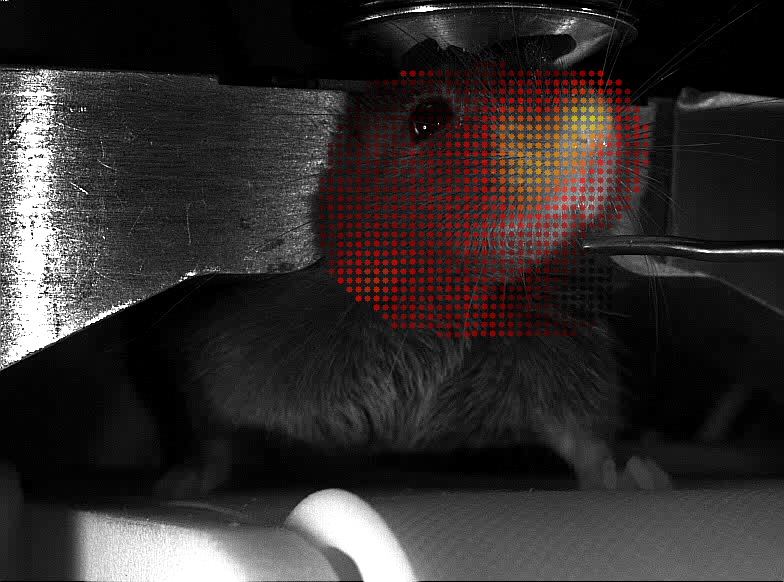

In [43]:
cmap = fr.helpers.simple_cmap(
    colors=[[0,0,0], [1,0,0], [1,1,0]], 
    over=[0,1,0], 
    under=[0,1,0], 
    bad=[0,1,0], 
)

factor_values = tca['20230430']['(points (xy))'][:]
factor_magnitudes = np.linalg.norm(factor_values.reshape(2, factor_values.shape[0]//2, -1), axis=0)

pts_tmp = data_pts['20230430']['point_positions'][:]
im_tmp = image

frame_visualizer = fr.visualization.FrameVisualizer(
    verbose=2,
    frame_height_width=im_tmp.shape[:2],
    point_sizes=3,
    alpha=0.6,
)

ims_factors_points = [frame_visualizer.visualize_image_with_points(image=im_tmp, points=pts_tmp, points_colors=[(cmap(f/f.max())*255).astype(np.int64)[:,:3]]) for f in factor_magnitudes.T] 

fr.visualization.display_toggle_image_stack(ims_factors_points)

In [ ]:
fig_tca_specFactor = plt.figure()
plt.plot(spec_data['frequencies'], tca_data['factors']['0']['frequency'])
plt.xscale('log')
plt.xlabel('frequency')
plt.legend(np.arange(tca_data['factors']['0']['frequency'].shape[1]) + 1);
plt.show()